In [ ]:
import spacy
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9 MB 1.3 MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-py3-none-any.whl size=829180942 sha256=0dbb7493941fd3faf1847edd5e2cbac6e5a4f5c55fbf3c06055a1902b5b35c4d
  Stored in directory: /tmp/pip-ephem-wheel-cache-sgm5rr2e/wheels/11/95/ba/2c36cc368c0bd339b44a791c2c1881a1fb714b78c29a4cb8f5
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [2]:
import json
import re
import time
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import en_core_web_lg
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

In [ ]:
nlp = en_core_web_lg.load()

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [3]:
from google.colab import drive, files
drive.mount('/content/drive')

TRAIN_SENTENCES_FILE_PATH = "/content/drive/MyDrive/Colab Notebooks/baseline_dataset/sentences_train.txt"
DEV_SENTENCES_FILE_PATH = "/content/drive/MyDrive/Colab Notebooks/baseline_dataset/sentences_dev.txt"
TEST_SENTENCES_FILE_PATH = "/content/drive/MyDrive/Colab Notebooks/baseline_dataset/sentences_test.txt"

TRAIN_DEP_FILE_PATH = "/content/drive/MyDrive/Colab Notebooks/baseline_dataset/dep_train.txt"
DEV_DEP_FILE_PATH = "/content/drive/MyDrive/Colab Notebooks/baseline_dataset/dep_dev.txt"
TEST_DEP_FILE_PATH = "/content/drive/MyDrive/Colab Notebooks/baseline_dataset/dep_test.txt"

TRAIN_LABELS_FILE_PATH = "/content/drive/MyDrive/Colab Notebooks/baseline_dataset/labels_train.txt"
DEV_LABELS_FILE_PATH = "/content/drive/MyDrive/Colab Notebooks/baseline_dataset/labels_dev.txt"
TEST_LABELS_FILE_PATH = "/content/drive/MyDrive/Colab Notebooks/baseline_dataset/labels_test.txt"

MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/entity_model.pth"


Mounted at /content/drive


In [ ]:
sentences = pd.read_csv(DEV_SENTENCES_FILE_PATH, delimiter='\t', header = None, names = ['sentence'])
sentences.head()

,sentence
0,put a credit card on a couch
1,move the credit card from the shelf to the sofa
2,move a credit card from a shelf to the couch
3,"turn around , go to the tall black shelves"
4,pick up the credit card on the shelf


In [ ]:
len(sentences)

6379

In [ ]:
# preprocess dependency parsing relations using one-hot encoding

# Collect all the dependency relations that occur in all the datasets
def collect_dep_relations(input_files):
    dep_set = set()
    
    for file in input_files:
        with open(file, "r") as f:
            for line in f:
                dep_list = line.split()
                for dep in dep_list:
                    dep_set.add(dep)

    return dep_set


# Transform the categorical column into their numerical counterparts, via the
# one-hot encoding scheme.
def create_dep_encoding(dep_set):
    ids = []
    id = 0
    dep_list = list(dep_set)

    for dep in dep_list:
        ids.append(id)
        id += 1
    
    df = pd.DataFrame(list(zip(ids, dep_list)), columns = ['Id', 'Dep'])
    dep_df = pd.get_dummies(df.Dep)

    return dep_df


# Return the vector of a dependency relation
# Ouput is a 41-dimensional vector
def get_dep_vector(dep_df, dep_string):

    try:
        return np.array(dep_df[dep_string].tolist(), dtype = np.float32)
    except KeyError as e:
        print("Error: Dependency relation not found")
        null_dep = np.zeros(depset_size, dtype = np.float32)
        return null_dep


In [ ]:
# Global parameters
batchsize_global = 16

# assign each label with a unique index
roleset_size = 5
role_to_idx = {"O": 0, "B-TARGET": 1, "I-TARGET": 2, "B-RECEPTACLE": 3, 
              "I-RECEPTACLE": 4}

# collect the dependency relation set, and represent each dep relation using 
# one-hot encoding
dep_set = collect_dep_relations({TRAIN_DEP_FILE_PATH, DEV_DEP_FILE_PATH, TEST_DEP_FILE_PATH})
dep_df = create_dep_encoding(dep_set)
# root_vector = get_dep_vector(dep_df, 'ROOT')

print("Number of dependency relations:", len(dep_set))

depset_size = 41
embedding_dim = 300

# parameters used in EntityLinker model
feature_dimension = depset_size + embedding_dim
hidden_dimension = 50

Number of dependency relations: 41


In [ ]:
print(dep_df)

    ROOT  acl  acomp  advcl  advmod  ...  prt  punct  quantmod  relcl  xcomp
0      0    1      0      0       0  ...    0      0         0      0      0
1      0    0      0      0       1  ...    0      0         0      0      0
2      0    0      0      0       0  ...    0      0         0      0      0
3      0    0      0      0       0  ...    0      0         0      0      0
4      0    0      0      0       0  ...    0      0         0      0      0
5      0    0      0      0       0  ...    0      0         0      0      0
6      0    0      0      0       0  ...    0      0         0      0      0
7      0    0      0      0       0  ...    0      0         0      0      0
8      0    0      0      0       0  ...    0      0         0      0      0
9      0    0      0      0       0  ...    0      0         0      0      0
10     0    0      0      0       0  ...    0      0         0      0      0
11     0    0      0      0       0  ...    0      0         0      1      0

maybe using segment id as a feature?

In [ ]:
#Initialising the dataset using pytorch
class ELDataset(Dataset):

    def __init__(self, nlp_model, sentence_file, dep_file, label_file, dep_feature = True, emb_feature = True):
        self.nlp = nlp_model
        self.sentence_file = pd.read_csv(sentence_file, delimiter='\t', 
                                     header = None, names = ['sentence'])
        self.dep_file = pd.read_csv(dep_file, delimiter='\t', 
                                    header = None, names = ['dependency'])
        self.label_file = pd.read_csv(label_file, delimiter='\t', 
                                      header = None, names = ['label'])
        # self.feature_dim = depset_size + embedding_dim
        self.dep_feature = dep_feature
        self.emb_feature = emb_feature

        if dep_feature and emb_feature:
            self.feature_dim = depset_size + embedding_dim
        elif not dep_feature: 
            self.feature_dim = embedding_dim
        elif not emb_feature:
            self.feature_dim = depset_size
    

    def __len__(self):
        assert len(self.sentence_file) == len(self.dep_file)
        assert len(self.sentence_file) == len(self.dep_file)
        return len(self.sentence_file)
    
    # ouput is a 300-dimensional vector (numpy.array)
    def get_spacy_embedding(self, token_string):
        token = token_string.lower()
        minimum_n_gram_len = 1

        # if the word has a vector, the result is the pre-trained vector;
        # if the word is out of vocabulary, then the resulting vector uses 
        # FastText’s subword features by average over n-grams of orth
        if self.nlp.vocab.has_vector(token):
            vector = self.nlp.vocab.get_vector(token)
        else:
            vector = self.nlp.vocab.get_vector(token, minn = minimum_n_gram_len)
        
        return vector
    
    # concatenate word embedding (300d) with dependency relation (41d)
    # output is a 341 dimensional feature (numpy.array)
    def prepare_token_feature(self, token_string, dep_string):
        vector = self.get_spacy_embedding(token_string)
        dep = get_dep_vector(dep_df, dep_string)
        if self.dep_feature and self.emb_feature:
            token_feature = np.append(vector, dep)
        elif not self.dep_feature: 
            token_feature = vector
        elif not self.emb_feature:
            token_feature = dep
        return token_feature
    
    # get the numerical value of the labels
    # return the a numpy array of labels for a sentence
    def prepare_labels(self, label_list, role_to_idx):
        ids = [role_to_idx[role] for role in label_list]
        return np.array(ids)
    
    
    def __getitem__(self, index):
        
        desc = self.sentence_file.loc[index, 'sentence'].split()
        dep = self.dep_file.loc[index, 'dependency'].split()
        label = self.label_file.loc[index, 'label'].split()

        token_count = len(desc)
        tensor_shape = (token_count, self.feature_dim,)
        sentence_tensor = torch.zeros(tensor_shape)

        token_idx = 0
        for token in desc:
            token_feature = self.prepare_token_feature(token, dep[token_idx])
            token_f_tensor = torch.from_numpy(token_feature).float()
            sentence_tensor[token_idx] = token_f_tensor
            token_idx += 1

        label_array = self.prepare_labels(label, role_to_idx)
        label_tensor = torch.from_numpy(label_array)

        return sentence_tensor, label_tensor


In [ ]:
# In a batch of the sentences, sequences have variable length, so we need to
# pad them to the same size
def pad_collate(batch):
    (xx, yy) = zip(*batch)
    # x_lens_t = torch.tensor([len(x) for x in xx])
    # y_lens_t = torch.tensor([len(y) for y in yy])

    x_lens = [len(x) for x in xx]
    y_lens = [len(y) for y in yy]

    padding_tensor = 0
    # the label for the pad token is -1
    padding_label = -1

    xx_pad = pad_sequence(xx, batch_first = True, padding_value = padding_tensor)
    yy_pad = pad_sequence(yy, batch_first = True, padding_value = padding_label)

    return xx_pad, yy_pad, x_lens, y_lens

In [ ]:
# create the dataset for training, validation and testing
train_set = ELDataset(nlp_model = nlp, sentence_file = TRAIN_SENTENCES_FILE_PATH, 
                      dep_file = TRAIN_DEP_FILE_PATH, 
                      label_file = TRAIN_LABELS_FILE_PATH)

dev_set = ELDataset(nlp_model = nlp, sentence_file = DEV_SENTENCES_FILE_PATH, 
                    dep_file = DEV_DEP_FILE_PATH, 
                    label_file = DEV_LABELS_FILE_PATH)

test_set = ELDataset(nlp_model = nlp, sentence_file = TEST_SENTENCES_FILE_PATH, 
                     dep_file = TEST_DEP_FILE_PATH, 
                     label_file = TEST_LABELS_FILE_PATH)

# Load the dataset
train_loader = DataLoader(train_set, batch_size = batchsize_global, 
                          shuffle=False, pin_memory=True, 
                          collate_fn = pad_collate)

dev_loader = DataLoader(dev_set, batch_size = batchsize_global, 
                        shuffle=False, pin_memory=True, 
                        collate_fn = pad_collate)

test_loader = DataLoader(test_set, batch_size = batchsize_global, 
                         shuffle=False, pin_memory=True, 
                         collate_fn = pad_collate)

print("Done loading datasets.")

Done loading datasets.


In [ ]:
class EntityLinker(nn.Module):
    
    def __init__(self, feature_dim, hidden_dim, roleset_size):
        super(EntityLinker, self).__init__()
        self.feature_dim = feature_dim
        self.hidden_dim = hidden_dim
        self.roleset_size = roleset_size

        self.lstm = nn.LSTM(self.feature_dim, self.hidden_dim, batch_first=True)
        self.cls_layer = nn.Linear(self.hidden_dim, self.roleset_size)
    
    def forward(self, input_features, input_lens):
        
        # print(input_features.shape)
        input_packed = pack_padded_sequence(input_features, 
                                            input_lens, batch_first = True, 
                                            enforce_sorted = False)
        
        # print("input packed shape:", input_packed.shape)
        lstm_out_packed, _ = self.lstm(input_packed)
        # print("output packed shape:", lstm_out_packed.batch_sizes)
        
        # lstm_out_padded shape: batch size x batch_max_len x lstm_hidden_dim
        lstm_out_padded, output_lengths = pad_packed_sequence(lstm_out_packed, 
                                                              batch_first = True)

        # label_out size: batch_size x batch_max_len x roleset_size
        label_out = self.cls_layer(lstm_out_padded)        
        
        return label_out

## Load GPU or CPU

In [ ]:
# calculate the cross entropy loss
def loss_fn(output_padded, labels, num_tokens):
    
    batch_ce_loss = 0.0
    
    for i in range(output_padded.size(0)):
        ce_loss = F.cross_entropy(output_padded[i], labels[i], reduction="sum", ignore_index=-1)
        batch_ce_loss += ce_loss
    
    loss = batch_ce_loss/num_tokens

    return loss

In [ ]:
# get the accuracy of predictions
def get_accuracy_from_scores(label_scores, label):
    role_scores = F.log_softmax(label_scores, dim=2)
    flatten_scores = role_scores.view(-1, label_scores.shape[2])

    flatten_labels = label.view(-1)
    mask = (flatten_labels >= 0).float()
    total_token = int(torch.sum(mask))

    correct_pred = 0
    all_preds = torch.tensor([])

    for i in range(flatten_labels.shape[0]):
        pred = torch.argmax(flatten_scores[i])
        
        if (flatten_labels[i] >= 0):
            pred_dim1 = torch.tensor([pred.item()])
            all_preds = torch.cat((all_preds, pred_dim1), dim=0)

            if (flatten_labels[i] == pred):
                correct_pred += 1

    acc = correct_pred / total_token
    # print(all_preds.shape, total_token)
    return acc, all_preds


# get fp, tp, fn of B-RECEPTACLE
def get_recep_results(label_scores, label):
    
    role_scores = F.log_softmax(label_scores, dim=2)
    flatten_scores = role_scores.view(-1, label_scores.shape[2])
    
    flatten_labels = label.view(-1)
    mask = (flatten_labels >= 0).float()
    total_token = int(torch.sum(mask))

    recep_count = 0
    tp = 0
    fp = 0
    fn = 0

    for i in range(flatten_labels.shape[0]):
        pred = torch.argmax(flatten_scores[i])
        if (flatten_labels[i] == 3):
            recep_count += 1
            if (pred == 3):
                tp += 1
            else:
                fn += 1
        elif (flatten_labels[i] >= 0):
            if (pred == 3 and flatten_labels[i] != 3):
                fp += 1
    
    # i_recep_f = tp/(tp + 0.5*(fp + fn))
    return recep_count, tp, fp, fn
            

In [ ]:
def evaluate(model, dev_loader, device):
    model.eval()

    mean_acc = 0
    count = 0
    rec_total = 0
    tps = 0
    fps = 0
    fns = 0
    
    all_preds = torch.tensor([])
    
    with torch.no_grad():
        for batch in dev_loader:
            x_padded, labels_padded, x_lens, labels_lens = batch
            input = x_padded.to(device)
            label = labels_padded.to(device)
            input_lens = x_lens
            label_lens = labels_lens

            label_scores = model(input, input_lens)
            
            acc, batch_preds = get_accuracy_from_scores(label_scores, label)
            all_preds = torch.cat((all_preds, batch_preds), dim=0)
            mean_acc += acc
            count += 1
            
            recep_count, tp, fp, fn = get_recep_results(label_scores, label)
            rec_total += recep_count
            tps += tp
            fps += fp
            fns += fn

    i_recep_f = tps/(tps + 0.5*(fps + fns))           
    
    return i_recep_f, mean_acc/count, all_preds

In [ ]:
def train(model, loss_fn, optimizer, train_loader, dev_loader, max_eps, device):

    st = time.time()
    dev_history = []
    best_dev_f = 0
    best_model = None

    for ep in range(max_eps):
        model.train()
        for iter, batch in enumerate(train_loader):
            optimizer.zero_grad()

            x_padded, labels_padded, x_lens, labels_lens = batch
            input = x_padded.to(device)
            label = labels_padded.to(device)
            input_lens = x_lens
            label_lens = labels_lens

            label_scores = model(input, input_lens)
            loss = loss_fn(label_scores, label, sum(label_lens))
            
            loss.backward()
            optimizer.step()
            
            if iter % 100 == 0:
                # acc, all_preds = get_accuracy_from_scores(label_scores, label)
                recep_count, tp, fp, fn = get_recep_results(label_scores, label)
                recep_f = tp/(tp + 0.5*(fp + fn))
                print("Iteration {} of epoch {} complete, Loss: {}; B-Receptacle f-score: {:0.3f}; Time taken (s): {}"
                    .format(iter, ep, loss.item(), recep_f, (time.time()-st)))
                st = time.time()
        
        dev_rec_f, dev_acc, dev_preds = evaluate(model, dev_loader, device)
        dev_history.append(dev_rec_f)
        print("Epoch {} complete! Development accuracy: {:0.3f}; Development B-RECEPTACLE f-score: {:0.3f};".format(ep, dev_acc, dev_rec_f))

        if dev_rec_f > best_dev_f:
            best_dev_f = dev_rec_f
            best_model = model
    
    return dev_history, best_model

In [ ]:
# Run the entity linker on GPU / CPU
model = EntityLinker(feature_dim = feature_dimension, 
                     hidden_dim = hidden_dimension, 
                     roleset_size = roleset_size)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr = 2e-3)
print("Done creating the entity linker")

Done creating the entity linker


In [ ]:
num_epoch = 20
development_recep_history, best_model = train(model, loss_fn, optimizer, train_loader, dev_loader, num_epoch, device)

Iteration 0 of epoch 0 complete, Loss: 1.594138503074646; B-Receptacle f-score: 0.000; Time taken (s): 0.3972296714782715
Iteration 100 of epoch 0 complete, Loss: 0.3831370770931244; B-Receptacle f-score: 0.583; Time taken (s): 4.1095898151397705
Iteration 200 of epoch 0 complete, Loss: 0.4553120732307434; B-Receptacle f-score: 0.000; Time taken (s): 4.344371557235718
Iteration 300 of epoch 0 complete, Loss: 0.10032480210065842; B-Receptacle f-score: 0.774; Time taken (s): 4.152836799621582
Iteration 400 of epoch 0 complete, Loss: 0.12925182282924652; B-Receptacle f-score: 0.000; Time taken (s): 4.257619380950928
Iteration 500 of epoch 0 complete, Loss: 0.07868731766939163; B-Receptacle f-score: 1.000; Time taken (s): 4.281137466430664
Iteration 600 of epoch 0 complete, Loss: 0.2097741812467575; B-Receptacle f-score: 0.000; Time taken (s): 4.204600811004639
Iteration 700 of epoch 0 complete, Loss: 0.05898120254278183; B-Receptacle f-score: 0.286; Time taken (s): 4.142670154571533
Itera

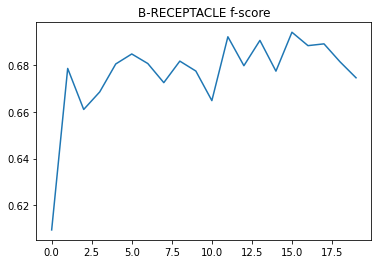

In [ ]:
plt.plot(development_recep_history)
plt.title("B-RECEPTACLE f-score")
plt.show()

## Performance on test set

In [ ]:
# get ground truth of the dataset
def get_dataset_labels(test_loader):
    all_labels = torch.tensor([])
    
    for batch in test_loader:
        x_padded, labels_padded, x_lens, labels_lens = batch
        flatten_labels = labels_padded.view(-1)
        mask = (flatten_labels >= 0).float()
        total_token = int(torch.sum(mask))

        for i in range(flatten_labels.shape[0]):
            if (flatten_labels[i] >= 0):
                label_dim1 = torch.tensor([flatten_labels[i].item()])
                all_labels = torch.cat((all_labels, label_dim1), dim=0)
    
    # print(all_labels.shape)
    return all_labels


In [ ]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

def plot_confusion_matrix(cm, classes, normalize=False, 
                          title = "Confusion Matrix", cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    accuracy = np.trace(cm) / float(np.sum(cm))

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}'.format(accuracy))


In [ ]:
# accuracy on test dataset

test_rec_f, test_acc, test_preds = evaluate(best_model, test_loader, device)
print("test B-RECEPTABLE f-score: ", test_rec_f)

test B-RECEPTABLE f-score:  0.6794243485025282


[[126299    389     63   2307    520]
 [   349   5731     18    138      0]
 [   323     95   1292      1    126]
 [  1399     36      1   4367    180]
 [   252      0     11     59    830]]
Confusion matrix, without normalization


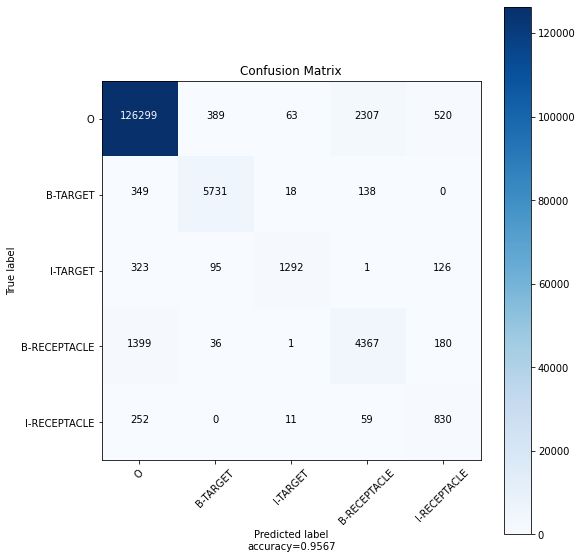

In [ ]:
# test_labels shape: total number of tokens in the dataloader
test_labels = get_dataset_labels(test_loader)
classes_name = list(role_to_idx)

cm = confusion_matrix(test_labels, test_preds)
print(cm)

plot_confusion_matrix(cm, classes_name)

In [ ]:
print(classification_report(test_labels, test_preds, target_names=classes_name))

              precision    recall  f1-score   support

           O       0.98      0.97      0.98    129578
    B-TARGET       0.92      0.92      0.92      6236
    I-TARGET       0.93      0.70      0.80      1837
B-RECEPTACLE       0.64      0.73      0.68      5983
I-RECEPTACLE       0.50      0.72      0.59      1152

    accuracy                           0.96    144786
   macro avg       0.79      0.81      0.79    144786
weighted avg       0.96      0.96      0.96    144786



## Evaluate the impact of dependency relation feature on the performance

In [ ]:
# create the dataset for training, validation and testing
train_set_300d = ELDataset(nlp_model = nlp, sentence_file = TRAIN_SENTENCES_FILE_PATH, 
                      dep_file = TRAIN_DEP_FILE_PATH, 
                      label_file = TRAIN_LABELS_FILE_PATH,
                      dep_feature = False)

dev_set_300d = ELDataset(nlp_model = nlp, sentence_file = DEV_SENTENCES_FILE_PATH, 
                    dep_file = DEV_DEP_FILE_PATH, 
                    label_file = DEV_LABELS_FILE_PATH, dep_feature = False)

test_set_300d = ELDataset(nlp_model = nlp, sentence_file = TEST_SENTENCES_FILE_PATH, 
                     dep_file = TEST_DEP_FILE_PATH, 
                     label_file = TEST_LABELS_FILE_PATH, dep_feature = False)

# Load the dataset
train_loader_300d = DataLoader(train_set_300d, batch_size = batchsize_global, 
                          shuffle=False, pin_memory=True, 
                          collate_fn = pad_collate)

dev_loader_300d = DataLoader(dev_set_300d, batch_size = batchsize_global, 
                        shuffle=False, pin_memory=True, 
                        collate_fn = pad_collate)

test_loader_300d = DataLoader(test_set_300d, batch_size = batchsize_global, 
                         shuffle=False, pin_memory=True, 
                         collate_fn = pad_collate)

print("Done loading datasets with 300d features.")

Done loading datasets with 300d features.


In [ ]:
print(train_set_300d[0][0][0].shape)

torch.Size([300])


In [ ]:
# Run the entity linker on GPU / CPU
model_300d = EntityLinker(feature_dim = embedding_dim, 
                     hidden_dim = hidden_dimension, 
                     roleset_size = roleset_size)
model_300d.to(device)
print("Done creating the entity linker with 300d features")

Done creating the entity linker with 300d features


In [ ]:
num_epoch = 15
optimizer = optim.Adam(model_300d.parameters(), lr = 2e-3)
dev_300d_history = train(model_300d, loss_fn, optimizer, train_loader_300d, dev_loader_300d, num_epoch, device)

Iteration 0 of epoch 0 complete, Loss: 0.08532711118459702; Receptacle Accuracy: 0.562; Time taken (s): 0.06673574447631836
Iteration 100 of epoch 0 complete, Loss: 0.06561009585857391; Receptacle Accuracy: 0.875; Time taken (s): 2.039106845855713
Iteration 200 of epoch 0 complete, Loss: 0.15936702489852905; Receptacle Accuracy: 0.154; Time taken (s): 2.1800730228424072
Iteration 300 of epoch 0 complete, Loss: 0.045895058661699295; Receptacle Accuracy: 0.700; Time taken (s): 2.0963027477264404
Iteration 400 of epoch 0 complete, Loss: 0.06879875063896179; Receptacle Accuracy: 0.154; Time taken (s): 2.1502509117126465
Iteration 500 of epoch 0 complete, Loss: 0.04571054130792618; Receptacle Accuracy: 0.667; Time taken (s): 2.050626039505005
Iteration 600 of epoch 0 complete, Loss: 0.16723741590976715; Receptacle Accuracy: 0.875; Time taken (s): 2.127401113510132
Iteration 700 of epoch 0 complete, Loss: 0.04356494918465614; Receptacle Accuracy: 0.571; Time taken (s): 2.11427640914917
Itera

[0.5375215146299483,
 0.5055077452667814,
 0.5433734939759036,
 0.5194492254733218,
 0.5862306368330464,
 0.5807228915662651,
 0.5963855421686747,
 0.5948364888123924,
 0.6211703958691911,
 0.6173838209982788,
 0.5948364888123924,
 0.6013769363166953,
 0.595697074010327,
 0.6036144578313253,
 0.6053356282271944]

In [ ]:
# accuracy on test dataset

test_rec_acc_300d, test_preds_300d = evaluate(model_300d, test_loader_300d, device)
print("test accuracy: ", test_rec_acc_300d)


test accuracy:  0.6477342628665163


[[131521    420     55   1621    309]
 [   275   4289     33     35      0]
 [   316    207    762      0     66]
 [  1479     23      1   2515      8]
 [   210      0      5     16    620]]
Confusion matrix, without normalization
              precision    recall  f1-score   support

           O       0.98      0.98      0.98    133926
    B-TARGET       0.87      0.93      0.90      4632
    I-TARGET       0.89      0.56      0.69      1351
B-RECEPTACLE       0.60      0.62      0.61      4026
I-RECEPTACLE       0.62      0.73      0.67       851

    accuracy                           0.96    144786
   macro avg       0.79      0.77      0.77    144786
weighted avg       0.97      0.96      0.96    144786



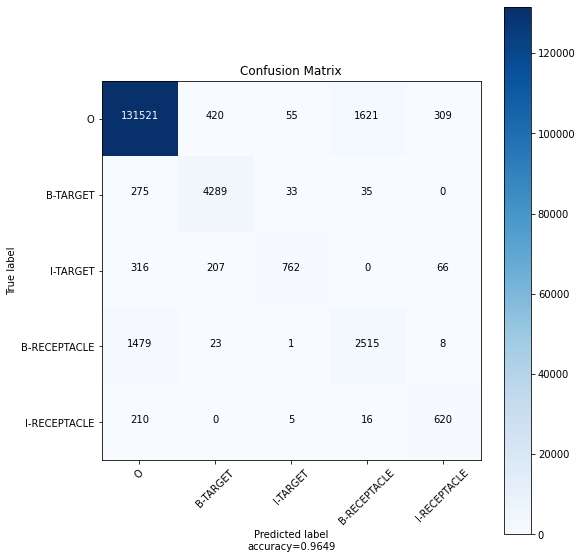

In [ ]:
cm_300d = confusion_matrix(test_labels, test_preds_300d)
print(cm_300d)
plot_confusion_matrix(cm_300d, classes_name)
print(classification_report(test_labels, test_preds_300d, target_names=classes_name))

##Using dependency parsing only

In [ ]:
# create the dataset for training, validation and testing
train_set_dep = ELDataset(nlp_model = nlp, sentence_file = TRAIN_SENTENCES_FILE_PATH, 
                      dep_file = TRAIN_DEP_FILE_PATH, 
                      label_file = TRAIN_LABELS_FILE_PATH,
                      emb_feature = False)

dev_set_dep = ELDataset(nlp_model = nlp, sentence_file = DEV_SENTENCES_FILE_PATH, 
                    dep_file = DEV_DEP_FILE_PATH, 
                    label_file = DEV_LABELS_FILE_PATH, emb_feature = False)

test_set_dep = ELDataset(nlp_model = nlp, sentence_file = TEST_SENTENCES_FILE_PATH, 
                     dep_file = TEST_DEP_FILE_PATH, 
                     label_file = TEST_LABELS_FILE_PATH, emb_feature = False)

# Load the dataset
train_loader_dep = DataLoader(train_set_dep, batch_size = batchsize_global, 
                          shuffle=False, pin_memory=True, 
                          collate_fn = pad_collate)

dev_loader_dep = DataLoader(dev_set_dep, batch_size = batchsize_global, 
                        shuffle=False, pin_memory=True, 
                        collate_fn = pad_collate)

test_loader_dep = DataLoader(test_set_dep, batch_size = batchsize_global, 
                         shuffle=False, pin_memory=True, 
                         collate_fn = pad_collate)

print("Done loading datasets with only dependency features.")

Done loading datasets with only dependency features.


In [ ]:
print(train_set_dep[0][0][0].shape)

torch.Size([41])


In [ ]:
# Run the entity linker on GPU / CPU
model_dep = EntityLinker(feature_dim = depset_size, 
                     hidden_dim = 20, 
                     roleset_size = roleset_size)
model_dep.to(device)
print("Done creating the entity linker with only dep features")

Done creating the entity linker with only dep features


In [ ]:
num_epoch = 15
optimizer = optim.Adam(model_dep.parameters(), lr = 2e-3)
dev_dep_history, dep_best_model = train(model_dep, loss_fn, optimizer, train_loader_dep, dev_loader_dep, num_epoch, device)

Iteration 0 of epoch 0 complete, Loss: 0.1806529015302658; B-Receptacle f-score: 0.222; Time taken (s): 0.06443285942077637
Iteration 100 of epoch 0 complete, Loss: 0.08621294796466827; B-Receptacle f-score: 0.750; Time taken (s): 3.0359199047088623
Iteration 200 of epoch 0 complete, Loss: 0.31397226452827454; B-Receptacle f-score: 0.087; Time taken (s): 3.0699427127838135
Iteration 300 of epoch 0 complete, Loss: 0.17773586511611938; B-Receptacle f-score: 0.286; Time taken (s): 3.022629737854004
Iteration 400 of epoch 0 complete, Loss: 0.1439291536808014; B-Receptacle f-score: 0.471; Time taken (s): 2.997635841369629
Iteration 500 of epoch 0 complete, Loss: 0.08620554953813553; B-Receptacle f-score: 0.500; Time taken (s): 2.9733760356903076
Iteration 600 of epoch 0 complete, Loss: 0.1555902510881424; B-Receptacle f-score: 0.250; Time taken (s): 3.0753049850463867
Iteration 700 of epoch 0 complete, Loss: 0.09513293951749802; B-Receptacle f-score: 0.933; Time taken (s): 3.061439037322998

In [ ]:
# accuracy on test dataset

test_rec_f_dep, test_rec_acc_dep, test_preds_dep = evaluate(model_dep, test_loader_dep, device)
print("test accuracy: ", test_rec_acc_dep)


test accuracy:  0.9392903056799663


[[126974   1035    143   1083    343]
 [   587   5587     15     46      1]
 [   114     88   1605      0     30]
 [  3938    336      4   1623     82]
 [   518      1    141     15    477]]
Confusion matrix, without normalization
              precision    recall  f1-score   support

           O       0.96      0.98      0.97    129578
    B-TARGET       0.79      0.90      0.84      6236
    I-TARGET       0.84      0.87      0.86      1837
B-RECEPTACLE       0.59      0.27      0.37      5983
I-RECEPTACLE       0.51      0.41      0.46      1152

    accuracy                           0.94    144786
   macro avg       0.74      0.69      0.70    144786
weighted avg       0.93      0.94      0.93    144786



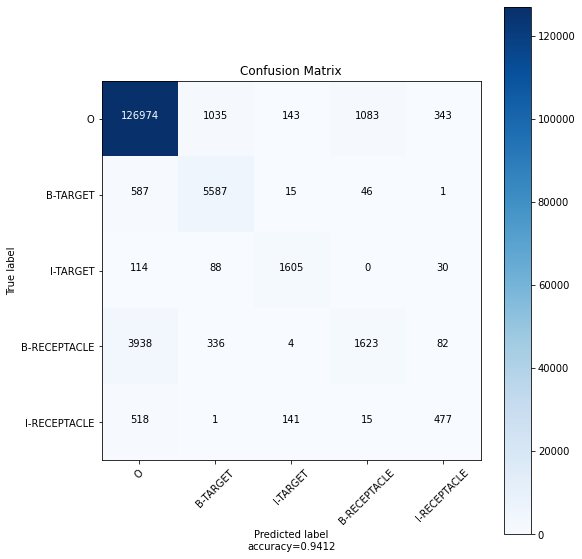

In [ ]:
cm_dep = confusion_matrix(test_labels, test_preds_dep)
print(cm_dep)
plot_confusion_matrix(cm_dep, classes_name)
print(classification_report(test_labels, test_preds_dep, target_names=classes_name))

## Hidden dimension size

In [ ]:
hidden_dims = [20, 30, 40, 50, 60, 70]
test_accs = []


for i in range(len(hidden_dims)):
    # model_hids = 0
    model_hids = EntityLinker(feature_dim = feature_dimension, 
                     hidden_dim = hidden_dims[i], 
                     roleset_size = roleset_size)
    model_hids.to(device)
    optimizer = optim.Adam(model_hids.parameters(), lr = 2e-3)
    print("model with {} hidden dimensions.".format(hidden_dims[i]))
    train(model_hids, loss_fn, optimizer, train_loader, dev_loader, 1, device)

    test_acc_hids, test_preds_hids = evaluate(model_hids, test_loader, device)
    print("test accuracy: ", test_acc_hids)
    test_accs.append(test_acc_hids)


model with 20 hidden dimensions.
Iteration 0 of epoch 0 complete, Loss: 1.5782471895217896; Accuracy: 0.22674418604651161; Time taken (s): 0.02499532699584961
Iteration 100 of epoch 0 complete, Loss: 0.35211381316185; Accuracy: 0.9073170731707317; Time taken (s): 2.8885514736175537
Iteration 200 of epoch 0 complete, Loss: 0.2521200180053711; Accuracy: 0.9442231075697212; Time taken (s): 3.2713682651519775
Iteration 300 of epoch 0 complete, Loss: 0.12472961097955704; Accuracy: 0.9563636363636364; Time taken (s): 3.04280686378479
Iteration 400 of epoch 0 complete, Loss: 0.10204175114631653; Accuracy: 0.9699570815450643; Time taken (s): 2.8509843349456787
Iteration 500 of epoch 0 complete, Loss: 0.11769593507051468; Accuracy: 0.9658792650918635; Time taken (s): 2.907857894897461
Iteration 600 of epoch 0 complete, Loss: 0.14603404700756073; Accuracy: 0.9459459459459459; Time taken (s): 3.0534732341766357
Iteration 700 of epoch 0 complete, Loss: 0.0749431699514389; Accuracy: 0.9789789789789

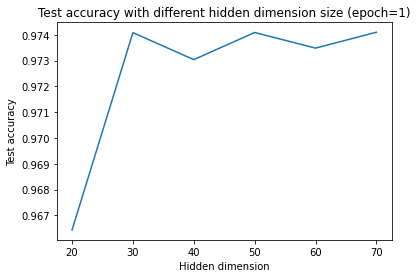

In [ ]:
plt.plot(hidden_dims, test_accs)
plt.title('Test accuracy with different hidden dimension size (epoch=1)')
plt.xlabel('Hidden dimension')
plt.ylabel('Test accuracy')
plt.show()

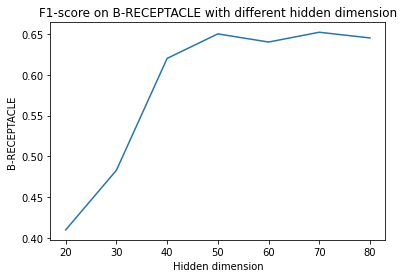

In [ ]:
import matplotlib.pyplot as plt
x = [20, 30, 40, 50, 60, 70, 80]
y = [0.41, 0.483, 0.62, 0.65, 0.64, 0.652, 0.645]

plt.xlabel("Hidden dimension")
plt.ylabel("B-RECEPTACLE")
plt.title('F1-score on B-RECEPTACLE with different hidden dimension')
plt.plot(x, y)
plt.show()

## Save and load model

In [ ]:
# save the model
model_save_name = 'entity_model.pth'
model_save_path = F"/content/drive/MyDrive/Colab Notebooks/{model_save_name}"
torch.save(best_model.state_dict(), model_save_path)

# download the model to the local drive
files.download(model_save_path) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# load the saved model from google drive
model_load = EntityLinker(feature_dim = feature_dimension, 
                     hidden_dim = hidden_dimension, 
                     roleset_size = roleset_size)
model_load.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu')))


<All keys matched successfully>

## process a single sentence

In [ ]:
# map index of label to the label (in string)
def idx_to_label(preds, role_to_idx):
    preds_string = []
    for result in preds:
        role = list(role_to_idx.keys())[list(role_to_idx.values()).index(result)]
        preds_string.append(role)
    return preds_string


# get the features of tokens in the sentence
def process_sentence(nlp, sentence_string):
    sentence_nlp = nlp(sentence_string.lower())

    num_token = len(sentence_nlp)
    tensor_shape = (num_token, feature_dimension)
    tokens_features_t = torch.zeros(tensor_shape)

    i = 0
    for token in sentence_nlp:
        dep = get_dep_vector(dep_df, token.dep_)
        vector = token.vector
        feature = np.append(vector, dep)
        feature_tensor = torch.from_numpy(feature).float()
        tokens_features_t[i] = feature_tensor
        i += 1

    return tokens_features_t
       

# predict labels of each token
def predict(model, nlp, sentence_string, role_to_idx):
    
    model.eval()
    features_t = process_sentence(nlp, sentence_string)
    input_lens = features_t.shape[0]

    input = features_t[None, :, :]
    predictions = []

    with torch.no_grad():
        label_scores = model(input, [input_lens])
        role_scores = F.log_softmax(label_scores, dim=2)
        flatten_scores = role_scores.view(-1, label_scores.shape[2])

        for i in range(input_lens):
            pred = torch.argmax(flatten_scores[i])
            
            predictions.append(pred.item())
        
        pred_roles = idx_to_label(predictions, role_to_idx)
    return pred_roles


In [ ]:
def get_target_and_recep(sentence_nlp, pred_roles):
    target = []
    receptacle = []

    i = 0    
    for label in pred_roles:
        token = sentence_nlp[i].text
        if label == 'B-TARGET':
            target.append(token)
        elif label == 'I-TARGET':
            item = target[-1] + ' ' + token
            target[-1] = item
        elif label == 'B-RECEPTACLE':
            receptacle.append(token)
        elif label == 'I-RECEPTACLE':
            item = receptacle[-1] + ' ' + token
            receptacle[-1] = item
        i += 1
    
    return target, receptacle


In [ ]:
sentence = "move the pillow to the chair and turn to the couch and "
sentence_nlp = nlp(sentence.lower())

result = predict(model_load, nlp, sentence, role_to_idx)
print(result)
target, receptacle = get_target_and_recep(sentence_nlp, result)
print("target:     {} \nreceptacle: {}".format(target, receptacle))


['O', 'O', 'B-TARGET', 'O', 'O', 'B-RECEPTACLE', 'O', 'O', 'O', 'O', 'O', 'O']
target:     ['pillow'] 
receptacle: ['chair']
